In [1]:
ASSET = "BTCUSDT"
TARGET = "Close"
SAVE_DF = f"./-for_optimization-/{ASSET}_{TARGET}_df.csv"
SAVE_SCALER = f"./-for_optimization-/{ASSET}_{TARGET}_scaler.pkl"
SAVE_MODEL = f"./-for_optimization-/{ASSET}_{TARGET}_model.keras"
SAVE_PREDICTIONS = f"./-for_optimization-/{ASSET}_{TARGET}_predictions.csv"


import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import importlib
# from __imports__ import *
import data, LSTM_returns
importlib.reload(data)


c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'data' from 'c:\\Users\\IC2594\\crypto\\folder-1\\data\\__init__.py'>

In [2]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    df['MA_7'] = df['Close'].rolling(window=7).mean()

    df['MA_14'] = df['Close'].rolling(window=14).mean()


    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df

df = data.load_asset(ASSET, sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = add_technical_features(df)
df = df[df.index >= '2022-01-01']
df = df[df.index <= '2025-01-01']
split = len(df[df.index >= '2024-06-01']) / len(df)
df.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope,MA_7,MA_14
Open time,,,,,,,,,,,,,,,,
2022-01-01,47722.65,19604.46325,Extreme Fear,0.032060,0.027996,43.994029,29.926197,888.17,1746.26,1737.70,-8.56,0.507208,0.000774,-90.927165,48077.968571,48548.405714
2022-01-02,47286.18,18340.46040,Fear,-0.009188,0.028115,42.744483,29.728726,604.95,1336.00,267.34,-1068.66,0.499858,0.000819,-188.546000,47579.495714,48591.616429
2022-01-03,46446.10,27662.07710,Fear,-0.017926,0.028524,40.367940,29.918303,-468.06,1874.00,283.82,-1590.18,0.488994,0.000685,-305.147231,46971.590000,48558.183571
2022-01-04,45832.01,35491.41360,Extreme Fear,-0.013310,0.025961,38.675184,30.169434,-3057.87,2057.54,1111.44,-946.10,0.498266,0.000620,-372.102857,46727.057143,48339.764286
2022-01-05,43451.13,51784.11857,Extreme Fear,-0.053346,0.029056,32.912682,31.372611,-5137.03,4570.00,1237.99,-3332.01,0.455508,0.000633,-503.589253,46296.552857,47972.833571


In [3]:
# Hyperparameters (from Optuna)
UNITS_L0 = 160
DROPOUT_L0 = 0.0
LEARNING_RATE = 0.000728
BATCH_SIZE = 32
MAX_EPOCHS = 50

def train_lstm(df, sequence_length=30, test_size=split, target='MA_7'):
    # Prepare data
    features = [
        'Close', 'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 
        'slope', 'MA_7', 'MA_14'
    ]
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    target_idx = list(df_all.columns).index(target)
    # Move the target column to the last position
    columns = list(df_all.columns)
    columns.append(columns.pop(target_idx))
    df_all = df_all[columns]
    target_idx = len(columns) - 1

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all)

    # Build sequences
    X, y = zip(*[
        (data_scaled[i-sequence_length:i], data_scaled[i, target_idx])
        for i in range(sequence_length, len(data_scaled))
    ])
    X, y = np.array(X), np.array(y)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Build and compile model
    model = Sequential([
        Input(shape=(sequence_length, X.shape[2])),
        LSTM(UNITS_L0, dropout=DROPOUT_L0),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

    # Train model
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)

    return model, scaler, history, (X_val, y_val), df_all, data_scaled



In [4]:
def objective(trial):
    global UNITS_L0, DROPOUT_L0, LEARNING_RATE, BATCH_SIZE, MAX_EPOCHS

    # Suggest hyperparameters
    UNITS_L0 = trial.suggest_int("units_l0", 50, 200)
    DROPOUT_L0 = trial.suggest_float("dropout_l0", 0.0, 0.5)
    LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    BATCH_SIZE = trial.suggest_categorical("batch_size", [16, 32, 64])
    MAX_EPOCHS = trial.suggest_int("max_epochs", 10, 100)
    sequence_length = trial.suggest_int("sequence_length", 10, 60)


    # Train the LSTM model
    model, scaler, history, (X_val, y_val), _, _ = train_lstm(
        df,
        sequence_length=sequence_length,
        test_size=split,
        target=TARGET
    )

    # Predict on validation set
    y_pred = model.predict(X_val).flatten()

    # Create a placeholder array with zeros, except for the last column (target)
    dummy = np.zeros((len(y_pred), X_val.shape[2]))
    dummy[:, -1] = y_pred

    # Inverse transform using the entire dummy array
    y_pred_inv = scaler.inverse_transform(dummy)[:, -1]

    # Inverse transform for the actual values
    dummy_y_val = np.zeros((len(y_val), X_val.shape[2]))
    dummy_y_val[:, -1] = y_val
    y_val_inv = scaler.inverse_transform(dummy_y_val)[:, -1]

    # Calculate MSE
    mse = mean_squared_error(y_val_inv, y_pred_inv)

    return mse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

[I 2025-05-09 19:33:39,546] A new study created in memory with name: no-name-4beddf11-c971-4bb6-bd30-9bd0172b9138


Epoch 1/70


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0317 - val_loss: 0.0323
Epoch 2/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0061 - val_loss: 0.0218
Epoch 3/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - val_loss: 0.0187
Epoch 4/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0052 - val_loss: 0.0188
Epoch 5/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0041 - val_loss: 0.0226
Epoch 6/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0032 - val_loss: 0.0339
Epoch 7/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0047 - val_loss: 0.0201
Epoch 8/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - val_loss: 0.0183
Epoch 9/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - val_loss: 0.0249
Epoch 10/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0024 - val_loss: 0.0253
Epoch 11/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030 - val_loss: 0.0133
Epoch 12/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0027 - val_l

[I 2025-05-09 19:33:55,193] Trial 0 finished with value: 108849828.90894237 and parameters: {'units_l0': 57, 'dropout_l0': 0.21593003356721535, 'learning_rate': 0.00040285358063664304, 'batch_size': 16, 'max_epochs': 70, 'sequence_length': 57}. Best is trial 0 with value: 108849828.90894237.


Epoch 1/31


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.1047 - val_loss: 0.0295
Epoch 2/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0077 - val_loss: 0.0175
Epoch 3/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0041 - val_loss: 0.0150
Epoch 4/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0029 - val_loss: 0.0131
Epoch 5/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0032 - val_loss: 0.0136
Epoch 6/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0030 - val_loss: 0.0148
Epoch 7/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0027 - val_loss: 0.0147
Epoch 8/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0027 - val_loss: 0.0203
Epoch 9/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0025 - val_loss: 0.0204
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2025-05-09 19:34:02,515] Trial 1 finished with value: 107154786.02410501 and parameters: {'units_l0': 81, 'dropout_l0': 0.17561720989593949, 'learning_rate': 0.004049290828941422, 'batch_size': 64, 'max_epochs': 31, 'sequence_length': 41}. Best is trial 1 with value: 107154786.02410501.


Epoch 1/99


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.1597 - val_loss: 0.1142
Epoch 2/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0129 - val_loss: 0.0362
Epoch 3/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0067 - val_loss: 0.0237
Epoch 4/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0068 - val_loss: 0.0360
Epoch 5/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0048 - val_loss: 0.0334
Epoch 6/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0053 - val_loss: 0.0373
Epoch 7/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0049 - val_loss: 0.0346
Epoch 8/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0055 - val_loss: 0.0375
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2025-05-09 19:34:10,777] Trial 2 finished with value: 193414347.1641749 and parameters: {'units_l0': 83, 'dropout_l0': 0.3651024722497192, 'learning_rate': 0.006405215265960968, 'batch_size': 64, 'max_epochs': 99, 'sequence_length': 40}. Best is trial 1 with value: 107154786.02410501.


Epoch 1/90


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0245 - val_loss: 0.0701
Epoch 2/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0081 - val_loss: 0.0283
Epoch 3/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0057 - val_loss: 0.0243
Epoch 4/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0049 - val_loss: 0.0212
Epoch 5/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0046 - val_loss: 0.0122
Epoch 6/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0038 - val_loss: 0.0222
Epoch 7/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039 - val_loss: 0.0148
Epoch 8/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0055 - val_loss: 0.0170
Epoch 9/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0035 - val_loss: 0.0147
Epoch 10/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0039 - val_loss: 0.0153
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-05-09 19:34:25,898] Trial 3 finished with value: 99665284.56548902 and parameters: {'units_l0': 104, 'dropout_l0': 0.25817204243949726, 'learning_rate': 7.608630419838187e-05, 'batch_size': 16, 'max_epochs': 90, 'sequence_length': 43}. Best is trial 3 with value: 99665284.56548902.


Epoch 1/21


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0755 - val_loss: 0.0254
Epoch 2/21
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0066 - val_loss: 0.0229
Epoch 3/21
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0054 - val_loss: 0.0321
Epoch 4/21
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0050 - val_loss: 0.0404
Epoch 5/21
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0056 - val_loss: 0.0375
Epoch 6/21
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0038 - val_loss: 0.0247
Epoch 7/21
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0045 - val_loss: 0.0516
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2025-05-09 19:34:35,163] Trial 4 finished with value: 186891707.82312858 and parameters: {'units_l0': 90, 'dropout_l0': 0.36687862931328946, 'learning_rate': 0.004883576992866173, 'batch_size': 16, 'max_epochs': 21, 'sequence_length': 26}. Best is trial 3 with value: 99665284.56548902.


Epoch 1/83


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0494 - val_loss: 0.1817
Epoch 2/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0185 - val_loss: 0.1162
Epoch 3/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0114 - val_loss: 0.0961
Epoch 4/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0076 - val_loss: 0.0664
Epoch 5/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0056 - val_loss: 0.0496
Epoch 6/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0055 - val_loss: 0.0390
Epoch 7/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043 - val_loss: 0.0305
Epoch 8/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0030 - val_loss: 0.0247
Epoch 9/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022 - val_loss: 0.0237
Epoch 10/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027 - val_loss: 0.0190
Epoch 11/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0028 - val_loss: 0.0167
Epoch 12/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018 - val_l

[I 2025-05-09 19:34:54,230] Trial 5 finished with value: 67782137.85753773 and parameters: {'units_l0': 120, 'dropout_l0': 0.05087142235505543, 'learning_rate': 3.146383548127757e-05, 'batch_size': 32, 'max_epochs': 83, 'sequence_length': 22}. Best is trial 5 with value: 67782137.85753773.


Epoch 1/69


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0504 - val_loss: 0.1067
Epoch 2/69
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0126 - val_loss: 0.0170
Epoch 3/69
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 4/69
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0046 - val_loss: 0.0152
Epoch 5/69
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0046 - val_loss: 0.0132
Epoch 6/69
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0044 - val_loss: 0.0160
Epoch 7/69
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0035 - val_loss: 0.0172
Epoch 8/69
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0044 - val_loss: 0.0148
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


[I 2025-05-09 19:34:59,587] Trial 6 finished with value: 82604166.67453639 and parameters: {'units_l0': 80, 'dropout_l0': 0.25738509291300926, 'learning_rate': 0.0006406944089468495, 'batch_size': 64, 'max_epochs': 69, 'sequence_length': 10}. Best is trial 5 with value: 67782137.85753773.


Epoch 1/64


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0953 - val_loss: 0.2754
Epoch 2/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0469 - val_loss: 0.1582
Epoch 3/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0277 - val_loss: 0.1127
Epoch 4/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0230 - val_loss: 0.1032
Epoch 5/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0200 - val_loss: 0.0962
Epoch 6/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0164 - val_loss: 0.0843
Epoch 7/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0142 - val_loss: 0.0750
Epoch 8/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0118 - val_loss: 0.0709
Epoch 9/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0120 - val_loss: 0.0599
Epoch 10/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0094 - val_loss: 0.0519
Epoch 11/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0082 - val_loss: 0.0441
Epoch 12/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0084 - val_l

[I 2025-05-09 19:35:16,756] Trial 7 finished with value: 129650679.9204789 and parameters: {'units_l0': 81, 'dropout_l0': 0.22351249241405885, 'learning_rate': 5.7618786075542945e-05, 'batch_size': 64, 'max_epochs': 64, 'sequence_length': 16}. Best is trial 5 with value: 67782137.85753773.


Epoch 1/49


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0551 - val_loss: 0.0201
Epoch 2/49
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0101 - val_loss: 0.0456
Epoch 3/49
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0049 - val_loss: 0.0139
Epoch 4/49
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0038 - val_loss: 0.0192
Epoch 5/49
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0024 - val_loss: 0.0161
Epoch 6/49
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0024 - val_loss: 0.0109
Epoch 7/49
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0020 - val_loss: 0.0091
Epoch 8/49
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0019 - val_loss: 0.0115
Epoch 9/49
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0016 - val_loss: 0.0103
Epoch 10/49
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0015 - val_loss: 0.0083
Epoch 11/49
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0022 - val_loss: 0.0095
Epoch 12/49
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0016 - val

[I 2025-05-09 19:35:48,319] Trial 8 finished with value: 52055000.24807798 and parameters: {'units_l0': 182, 'dropout_l0': 0.0576292550362823, 'learning_rate': 0.00012334264259911603, 'batch_size': 64, 'max_epochs': 49, 'sequence_length': 39}. Best is trial 8 with value: 52055000.24807798.


Epoch 1/82


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0233 - val_loss: 0.0216
Epoch 2/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0075 - val_loss: 0.0264
Epoch 3/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0058 - val_loss: 0.0234
Epoch 4/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0055 - val_loss: 0.0285
Epoch 5/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0056 - val_loss: 0.0369
Epoch 6/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0047 - val_loss: 0.0539
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


[I 2025-05-09 19:36:00,574] Trial 9 finished with value: 176672746.72776496 and parameters: {'units_l0': 80, 'dropout_l0': 0.3714617274464617, 'learning_rate': 0.0016290963873801135, 'batch_size': 16, 'max_epochs': 82, 'sequence_length': 29}. Best is trial 8 with value: 52055000.24807798.


Epoch 1/42


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0674 - val_loss: 0.3844
Epoch 2/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0389 - val_loss: 0.2725
Epoch 3/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0269 - val_loss: 0.2173
Epoch 4/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0220 - val_loss: 0.1837
Epoch 5/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0192 - val_loss: 0.1570
Epoch 6/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0146 - val_loss: 0.1315
Epoch 7/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0114 - val_loss: 0.1123
Epoch 8/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0088 - val_loss: 0.0927
Epoch 9/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0075 - val_loss: 0.0748
Epoch 10/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0055 - val_loss: 0.0609
Epoch 11/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0044 - val_loss: 0.0492
Epoch 12/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0030 - val_l

[I 2025-05-09 19:37:10,668] Trial 10 finished with value: 49679840.387320705 and parameters: {'units_l0': 183, 'dropout_l0': 0.0003007201435770712, 'learning_rate': 1.2962292399256767e-05, 'batch_size': 32, 'max_epochs': 42, 'sequence_length': 54}. Best is trial 10 with value: 49679840.387320705.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0370 - val_loss: 0.1933
Epoch 2/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0197 - val_loss: 0.1363
Epoch 3/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0119 - val_loss: 0.1066
Epoch 4/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0095 - val_loss: 0.0886
Epoch 5/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0080 - val_loss: 0.0785
Epoch 6/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0057 - val_loss: 0.0695
Epoch 7/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0053 - val_loss: 0.0613
Epoch 8/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0044 - val_loss: 0.0541
Epoch 9/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0037 - val_loss: 0.0483
Epoch 10/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0031 - val_loss: 0.0440
Epoch 11/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0030 - val_loss: 0.0398
Epoch 12/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0

[I 2025-05-09 19:38:26,420] Trial 11 finished with value: 88963619.29162566 and parameters: {'units_l0': 185, 'dropout_l0': 0.0013464557814705236, 'learning_rate': 1.0095314339362415e-05, 'batch_size': 32, 'max_epochs': 44, 'sequence_length': 55}. Best is trial 10 with value: 49679840.387320705.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0235 - val_loss: 0.0217
Epoch 2/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0036 - val_loss: 0.0111
Epoch 3/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0026 - val_loss: 0.0085
Epoch 4/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0019 - val_loss: 0.0097
Epoch 5/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0023 - val_loss: 0.0099
Epoch 6/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0016 - val_loss: 0.0077
Epoch 7/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0023 - val_loss: 0.0116
Epoch 8/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0018 - val_loss: 0.0073
Epoch 9/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 10/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0016 - val_loss: 0.0110
Epoch 11/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0018 - val_loss: 0.0104
Epoch 12/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0

[I 2025-05-09 19:38:50,399] Trial 12 finished with value: 53219632.72760723 and parameters: {'units_l0': 184, 'dropout_l0': 0.10186387480346243, 'learning_rate': 0.0001507189706814237, 'batch_size': 32, 'max_epochs': 44, 'sequence_length': 50}. Best is trial 10 with value: 49679840.387320705.


Epoch 1/48


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0549 - val_loss: 0.3321
Epoch 2/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0289 - val_loss: 0.2467
Epoch 3/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0218 - val_loss: 0.1991
Epoch 4/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0171 - val_loss: 0.1758
Epoch 5/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0171 - val_loss: 0.1553
Epoch 6/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0151 - val_loss: 0.1432
Epoch 7/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0122 - val_loss: 0.1285
Epoch 8/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0109 - val_loss: 0.1144
Epoch 9/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0091 - val_loss: 0.1037
Epoch 10/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0097 - val_loss: 0.0939
Epoch 11/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0077 - val_loss: 0.0826
Epoch 12/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0069 - val_l

[I 2025-05-09 19:39:25,986] Trial 13 finished with value: 150540941.5426071 and parameters: {'units_l0': 161, 'dropout_l0': 0.10086800682082164, 'learning_rate': 1.1409548762860394e-05, 'batch_size': 32, 'max_epochs': 48, 'sequence_length': 34}. Best is trial 10 with value: 49679840.387320705.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0181 - val_loss: 0.1307
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0134 - val_loss: 0.1049
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0083 - val_loss: 0.0921
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0061 - val_loss: 0.0687
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0038 - val_loss: 0.0569
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0030 - val_loss: 0.0448
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0022 - val_loss: 0.0361
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0015 - val_loss: 0.0318
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0014 - val_loss: 0.0269
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0013 - val_loss: 0.0243
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-05-09 19:39:40,362] Trial 14 finished with value: 198601607.99729517 and parameters: {'units_l0': 152, 'dropout_l0': 0.0034915621391160556, 'learning_rate': 2.677127083890379e-05, 'batch_size': 64, 'max_epochs': 10, 'sequence_length': 48}. Best is trial 10 with value: 49679840.387320705.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0802 - val_loss: 0.0949
Epoch 2/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0166 - val_loss: 0.0458
Epoch 3/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0098 - val_loss: 0.0345
Epoch 4/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0084 - val_loss: 0.0309
Epoch 5/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0085 - val_loss: 0.0489
Epoch 6/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0098 - val_loss: 0.0457
Epoch 7/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0094 - val_loss: 0.0473
Epoch 8/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0068 - val_loss: 0.0446
Epoch 9/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0094 - val_loss: 0.0238
Epoch 10/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0093 - val_loss: 0.0458
Epoch 11/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0085 - val_loss: 0.0320
Epoch 12/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.

[I 2025-05-09 19:40:09,936] Trial 15 finished with value: 194533950.94319838 and parameters: {'units_l0': 198, 'dropout_l0': 0.4933141534064988, 'learning_rate': 0.0001715531609650611, 'batch_size': 32, 'max_epochs': 31, 'sequence_length': 59}. Best is trial 10 with value: 49679840.387320705.


Epoch 1/55


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.0539 - val_loss: 0.0047
Epoch 2/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0081 - val_loss: 0.0055
Epoch 3/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0027 - val_loss: 0.0147
Epoch 4/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0023 - val_loss: 0.0130
Epoch 5/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0018 - val_loss: 0.0156
Epoch 6/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0019 - val_loss: 0.0122
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-05-09 19:40:21,379] Trial 16 finished with value: 38715603.5525539 and parameters: {'units_l0': 150, 'dropout_l0': 0.0898000006396595, 'learning_rate': 0.0009973279404177373, 'batch_size': 64, 'max_epochs': 55, 'sequence_length': 48}. Best is trial 16 with value: 38715603.5525539.


Epoch 1/62


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0260 - val_loss: 0.0221
Epoch 2/62
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0029 - val_loss: 0.0106
Epoch 3/62
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0028 - val_loss: 0.0110
Epoch 4/62
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0021 - val_loss: 0.0124
Epoch 5/62
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0019 - val_loss: 0.0188
Epoch 6/62
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0017 - val_loss: 0.0119
Epoch 7/62
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0021 - val_loss: 0.0228
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-05-09 19:40:33,840] Trial 17 finished with value: 86212695.22853477 and parameters: {'units_l0': 146, 'dropout_l0': 0.11892720764020512, 'learning_rate': 0.0010298297840957563, 'batch_size': 32, 'max_epochs': 62, 'sequence_length': 50}. Best is trial 16 with value: 38715603.5525539.


Epoch 1/35


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0510 - val_loss: 0.0153
Epoch 2/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0037 - val_loss: 0.0211
Epoch 3/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0032 - val_loss: 0.0230
Epoch 4/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0025 - val_loss: 0.0221
Epoch 5/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0019 - val_loss: 0.0252
Epoch 6/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0030 - val_loss: 0.0264
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


[I 2025-05-09 19:40:47,240] Trial 18 finished with value: 124596764.52638449 and parameters: {'units_l0': 135, 'dropout_l0': 0.16433659497855296, 'learning_rate': 0.0020241783676794695, 'batch_size': 32, 'max_epochs': 35, 'sequence_length': 47}. Best is trial 16 with value: 38715603.5525539.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 0.0351 - val_loss: 0.0537
Epoch 2/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0040 - val_loss: 0.0074
Epoch 3/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0021 - val_loss: 0.0185
Epoch 4/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0017 - val_loss: 0.0100
Epoch 5/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0012 - val_loss: 0.0082
Epoch 6/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0015 - val_loss: 0.0083
Epoch 7/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0010 - val_loss: 0.0074
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2025-05-09 19:41:01,685] Trial 19 finished with value: 60283637.55599182 and parameters: {'units_l0': 167, 'dropout_l0': 0.04912684290404925, 'learning_rate': 0.00036850115359341444, 'batch_size': 64, 'max_epochs': 52, 'sequence_length': 54}. Best is trial 16 with value: 38715603.5525539.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - loss: 0.3768 - val_loss: 0.1045
Epoch 2/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0082 - val_loss: 0.0319
Epoch 3/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0045 - val_loss: 0.0176
Epoch 4/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0034 - val_loss: 0.0224
Epoch 5/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0027 - val_loss: 0.0193
Epoch 6/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0028 - val_loss: 0.0156
Epoch 7/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0025 - val_loss: 0.0258
Epoch 8/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0021 - val_loss: 0.0108
Epoch 9/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0048 - val_loss: 0.0276
Epoch 10/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0031 - val_loss: 0.0289
Epoch 11/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0024 - val_loss: 0.0143
Epoch 12/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.

[I 2025-05-09 19:41:19,384] Trial 20 finished with value: 87905517.88611954 and parameters: {'units_l0': 125, 'dropout_l0': 0.1451242023413814, 'learning_rate': 0.00968416729488716, 'batch_size': 64, 'max_epochs': 57, 'sequence_length': 60}. Best is trial 16 with value: 38715603.5525539.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/39
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0510 - val_loss: 0.1393
Epoch 2/39
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0100 - val_loss: 0.0303
Epoch 3/39
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0036 - val_loss: 0.0162
Epoch 4/39
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0025 - val_loss: 0.0130
Epoch 5/39
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0022 - val_loss: 0.0112
Epoch 6/39
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0019 - val_loss: 0.0123
Epoch 7/39
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0016 - val_loss: 0.0122
Epoch 8/39
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0016 - val_loss: 0.0096
Epoch 9/39
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0011 - val_loss: 0.0093
Epoch 10/39
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0014 - val_loss: 0.0099
Epoch 11/39
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0012 - val_loss: 0.0101
Epoch 12/39
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.

[I 2025-05-09 19:41:42,458] Trial 21 finished with value: 45139407.01241717 and parameters: {'units_l0': 175, 'dropout_l0': 0.05189160577686334, 'learning_rate': 0.0001481228247099824, 'batch_size': 64, 'max_epochs': 39, 'sequence_length': 34}. Best is trial 16 with value: 38715603.5525539.


Epoch 1/38


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.0383 - val_loss: 0.1470
Epoch 2/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0222 - val_loss: 0.0929
Epoch 3/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0191 - val_loss: 0.0766
Epoch 4/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0138 - val_loss: 0.0631
Epoch 5/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0105 - val_loss: 0.0481
Epoch 6/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0082 - val_loss: 0.0378
Epoch 7/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0071 - val_loss: 0.0317
Epoch 8/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0056 - val_loss: 0.0237
Epoch 9/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0046 - val_loss: 0.0205
Epoch 10/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0042 - val_loss: 0.0164
Epoch 11/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0028 - val_loss: 0.0152
Epoch 12/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0027 - val_

[I 2025-05-09 19:42:11,915] Trial 22 finished with value: 61960365.59716659 and parameters: {'units_l0': 172, 'dropout_l0': 0.0445517009341577, 'learning_rate': 2.4748123428136632e-05, 'batch_size': 64, 'max_epochs': 38, 'sequence_length': 33}. Best is trial 16 with value: 38715603.5525539.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0456 - val_loss: 0.0072
Epoch 2/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0088 - val_loss: 0.0162
Epoch 3/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0034 - val_loss: 0.0210
Epoch 4/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0020 - val_loss: 0.0189
Epoch 5/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0021 - val_loss: 0.0122
Epoch 6/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0015 - val_loss: 0.0084
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2025-05-09 19:42:24,036] Trial 23 finished with value: 59045565.6130883 and parameters: {'units_l0': 198, 'dropout_l0': 0.08368276983256179, 'learning_rate': 0.0008983227145633519, 'batch_size': 64, 'max_epochs': 23, 'sequence_length': 36}. Best is trial 16 with value: 38715603.5525539.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0181 - val_loss: 0.0413
Epoch 2/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0030 - val_loss: 0.0114
Epoch 3/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0015 - val_loss: 0.0181
Epoch 4/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0011 - val_loss: 0.0178
Epoch 5/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 7.3914e-04 - val_loss: 0.0133
Epoch 6/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 6.8843e-04 - val_loss: 0.0107
Epoch 7/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 6.6931e-04 - val_loss: 0.0128
Epoch 8/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 5.5961e-04 - val_loss: 0.0090
Epoch 9/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.2343e-04 - val_loss: 0.0093
Epoch 10/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.0495e-04 - val_loss: 0.0086
Epoch 11/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3.3094e-04 - val_loss: 0.0062
Epoch 12/23
14/14 ━━━━━━━━━━━━━━━━

[I 2025-05-09 19:42:46,677] Trial 24 finished with value: 47479945.80118529 and parameters: {'units_l0': 145, 'dropout_l0': 0.00017779449891621585, 'learning_rate': 0.00023638554920434724, 'batch_size': 64, 'max_epochs': 23, 'sequence_length': 45}. Best is trial 16 with value: 38715603.5525539.


Epoch 1/21


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0629 - val_loss: 0.0554
Epoch 2/21
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0123 - val_loss: 0.0214
Epoch 3/21
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0096 - val_loss: 0.0184
Epoch 4/21
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0064 - val_loss: 0.0202
Epoch 5/21
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0058 - val_loss: 0.0240
Epoch 6/21
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0062 - val_loss: 0.0189
Epoch 7/21
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0055 - val_loss: 0.0247
Epoch 8/21
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0055 - val_loss: 0.0256
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-05-09 19:42:57,646] Trial 25 finished with value: 150600376.71488455 and parameters: {'units_l0': 146, 'dropout_l0': 0.3095748961428791, 'learning_rate': 0.00021004340843174655, 'batch_size': 64, 'max_epochs': 21, 'sequence_length': 44}. Best is trial 16 with value: 38715603.5525539.


Epoch 1/14


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0548 - val_loss: 0.0882
Epoch 2/14
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0079 - val_loss: 0.0217
Epoch 3/14
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0041 - val_loss: 0.0113
Epoch 4/14
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0034 - val_loss: 0.0127
Epoch 5/14
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0026 - val_loss: 0.0106
Epoch 6/14
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0021 - val_loss: 0.0116
Epoch 7/14
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0025 - val_loss: 0.0117
Epoch 8/14
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0023 - val_loss: 0.0086
Epoch 9/14
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0023 - val_loss: 0.0108
Epoch 10/14
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026 - val_loss: 0.0115
Epoch 11/14
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 0.0084
Epoch 12/14
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0025 - val_l

[I 2025-05-09 19:43:11,703] Trial 26 finished with value: 68871658.45180838 and parameters: {'units_l0': 132, 'dropout_l0': 0.13204991564175197, 'learning_rate': 0.0005356957687539969, 'batch_size': 64, 'max_epochs': 14, 'sequence_length': 28}. Best is trial 16 with value: 38715603.5525539.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0462 - val_loss: 0.0874
Epoch 2/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0069 - val_loss: 0.0075
Epoch 3/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0032 - val_loss: 0.0117
Epoch 4/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0028 - val_loss: 0.0162
Epoch 5/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0018 - val_loss: 0.0104
Epoch 6/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0020 - val_loss: 0.0076
Epoch 7/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0017 - val_loss: 0.0096
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-05-09 19:43:22,372] Trial 27 finished with value: 61595557.69645576 and parameters: {'units_l0': 156, 'dropout_l0': 0.07581607822629355, 'learning_rate': 0.0002725168145520674, 'batch_size': 64, 'max_epochs': 27, 'sequence_length': 46}. Best is trial 16 with value: 38715603.5525539.


Epoch 1/56


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0601 - val_loss: 0.1646
Epoch 2/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0293 - val_loss: 0.1318
Epoch 3/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0156 - val_loss: 0.0668
Epoch 4/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0094 - val_loss: 0.0447
Epoch 5/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0058 - val_loss: 0.0226
Epoch 6/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0033 - val_loss: 0.0139
Epoch 7/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0022 - val_loss: 0.0078
Epoch 8/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0019 - val_loss: 0.0072
Epoch 9/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0020 - val_loss: 0.0067
Epoch 10/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0017 - val_loss: 0.0071
Epoch 11/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0011 - val_loss: 0.0061
Epoch 12/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0014 - val_

[I 2025-05-09 19:43:52,237] Trial 28 finished with value: 24488858.285416517 and parameters: {'units_l0': 172, 'dropout_l0': 0.03247642597101886, 'learning_rate': 8.115739331603387e-05, 'batch_size': 64, 'max_epochs': 56, 'sequence_length': 38}. Best is trial 28 with value: 24488858.285416517.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1286 - val_loss: 0.1229
Epoch 2/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0132 - val_loss: 0.0324
Epoch 3/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0068 - val_loss: 0.0194
Epoch 4/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0050 - val_loss: 0.0117
Epoch 5/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0046 - val_loss: 0.0127
Epoch 6/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0038 - val_loss: 0.0095
Epoch 7/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0040 - val_loss: 0.0110
Epoch 8/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0039 - val_loss: 0.0127
Epoch 9/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0039 - val_loss: 0.0168
Epoch 10/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0036 - val_loss: 0.0205
Epoch 11/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0038 - val_loss: 0.0141
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-05-09 19:44:09,394] Trial 29 finished with value: 77653980.70853256 and parameters: {'units_l0': 169, 'dropout_l0': 0.20618706601539075, 'learning_rate': 8.517787556904134e-05, 'batch_size': 16, 'max_epochs': 55, 'sequence_length': 38}. Best is trial 28 with value: 24488858.285416517.


Epoch 1/78


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0244 - val_loss: 0.0724
Epoch 2/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0113 - val_loss: 0.0535
Epoch 3/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0066 - val_loss: 0.0372
Epoch 4/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0037 - val_loss: 0.0198
Epoch 5/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0025 - val_loss: 0.0126
Epoch 6/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0024 - val_loss: 0.0087
Epoch 7/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0017 - val_loss: 0.0056
Epoch 8/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0016 - val_loss: 0.0059
Epoch 9/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0014 - val_loss: 0.0054
Epoch 10/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0011 - val_loss: 0.0065
Epoch 11/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 12/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0012 - val_

[I 2025-05-09 19:44:31,362] Trial 30 finished with value: 29522285.98351815 and parameters: {'units_l0': 175, 'dropout_l0': 0.033373452464184175, 'learning_rate': 4.385629121910697e-05, 'batch_size': 64, 'max_epochs': 78, 'sequence_length': 32}. Best is trial 28 with value: 24488858.285416517.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0343 - val_loss: 0.1482
Epoch 2/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0180 - val_loss: 0.1157
Epoch 3/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0104 - val_loss: 0.0932
Epoch 4/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0055 - val_loss: 0.0583
Epoch 5/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0039 - val_loss: 0.0475
Epoch 6/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0030 - val_loss: 0.0324
Epoch 7/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0026 - val_loss: 0.0269
Epoch 8/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0022 - val_loss: 0.0230
Epoch 9/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0020 - val_loss: 0.0199
Epoch 10/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0022 - val_loss: 0.0180
Epoch 11/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0017 - val_loss: 0.0163
Epoch 12/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.

[I 2025-05-09 19:45:07,041] Trial 31 finished with value: 44096118.40834038 and parameters: {'units_l0': 175, 'dropout_l0': 0.03704830062393824, 'learning_rate': 4.3346589677610365e-05, 'batch_size': 64, 'max_epochs': 76, 'sequence_length': 32}. Best is trial 28 with value: 24488858.285416517.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0472 - val_loss: 0.2556
Epoch 2/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0290 - val_loss: 0.1944
Epoch 3/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0219 - val_loss: 0.1880
Epoch 4/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0169 - val_loss: 0.1439
Epoch 5/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0121 - val_loss: 0.1176
Epoch 6/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0091 - val_loss: 0.0954
Epoch 7/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0079 - val_loss: 0.0715
Epoch 8/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0051 - val_loss: 0.0613
Epoch 9/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0045 - val_loss: 0.0486
Epoch 10/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0039 - val_loss: 0.0435
Epoch 11/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0038 - val_loss: 0.0375
Epoch 12/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0

[I 2025-05-09 19:45:39,064] Trial 32 finished with value: 51441896.313397765 and parameters: {'units_l0': 161, 'dropout_l0': 0.0307153296206936, 'learning_rate': 4.1631384302756727e-05, 'batch_size': 64, 'max_epochs': 76, 'sequence_length': 31}. Best is trial 28 with value: 24488858.285416517.


Epoch 1/73


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.1098 - val_loss: 0.4384
Epoch 2/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0648 - val_loss: 0.3168
Epoch 3/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0348 - val_loss: 0.2278
Epoch 4/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0213 - val_loss: 0.1704
Epoch 5/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0160 - val_loss: 0.1348
Epoch 6/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0118 - val_loss: 0.1144
Epoch 7/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0097 - val_loss: 0.1017
Epoch 8/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0088 - val_loss: 0.0911
Epoch 9/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0080 - val_loss: 0.0829
Epoch 10/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0070 - val_loss: 0.0736
Epoch 11/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0064 - val_loss: 0.0646
Epoch 12/73
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0055 - val_l

[I 2025-05-09 19:46:10,550] Trial 33 finished with value: 94427577.64521119 and parameters: {'units_l0': 191, 'dropout_l0': 0.08408011173336628, 'learning_rate': 1.8899823568257753e-05, 'batch_size': 64, 'max_epochs': 73, 'sequence_length': 23}. Best is trial 28 with value: 24488858.285416517.


Epoch 1/99


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0210 - val_loss: 0.1154
Epoch 2/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0175 - val_loss: 0.1015
Epoch 3/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0145 - val_loss: 0.0859
Epoch 4/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0121 - val_loss: 0.0748
Epoch 5/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0117 - val_loss: 0.0626
Epoch 6/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0118 - val_loss: 0.0562
Epoch 7/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0078 - val_loss: 0.0492
Epoch 8/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0080 - val_loss: 0.0484
Epoch 9/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0065 - val_loss: 0.0396
Epoch 10/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0072 - val_loss: 0.0411
Epoch 11/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0055 - val_loss: 0.0351
Epoch 12/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0063 - val_l

[I 2025-05-09 19:46:22,344] Trial 34 finished with value: 147451383.51938522 and parameters: {'units_l0': 62, 'dropout_l0': 0.18433682572811544, 'learning_rate': 4.471285784780752e-05, 'batch_size': 64, 'max_epochs': 99, 'sequence_length': 41}. Best is trial 28 with value: 24488858.285416517.


Epoch 1/89


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0433 - val_loss: 0.0308
Epoch 2/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0102 - val_loss: 0.0440
Epoch 3/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0039 - val_loss: 0.0201
Epoch 4/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0026 - val_loss: 0.0207
Epoch 5/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0018 - val_loss: 0.0168
Epoch 6/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0015 - val_loss: 0.0160
Epoch 7/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0015 - val_loss: 0.0126
Epoch 8/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0013 - val_loss: 0.0139
Epoch 9/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0012 - val_loss: 0.0128
Epoch 10/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0012 - val_loss: 0.0119
Epoch 11/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 9.9990e-04 - val_loss: 0.0107
Epoch 12/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0012 - v

[I 2025-05-09 19:46:40,287] Trial 35 finished with value: 35742175.81944918 and parameters: {'units_l0': 174, 'dropout_l0': 0.0220149801930396, 'learning_rate': 9.426834066126756e-05, 'batch_size': 64, 'max_epochs': 89, 'sequence_length': 37}. Best is trial 28 with value: 24488858.285416517.


Epoch 1/92


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0227 - val_loss: 0.0401
Epoch 2/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0051 - val_loss: 0.0203
Epoch 3/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0032 - val_loss: 0.0182
Epoch 4/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023 - val_loss: 0.0142
Epoch 5/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0024 - val_loss: 0.0117
Epoch 6/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0027 - val_loss: 0.0110
Epoch 7/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0027 - val_loss: 0.0115
Epoch 8/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0028 - val_loss: 0.0133
Epoch 9/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - val_loss: 0.0184
Epoch 10/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - val_loss: 0.0152
Epoch 11/92
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017 - val_loss: 0.0173
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[I 2025-05-09 19:46:49,056] Trial 36 finished with value: 89713466.44610368 and parameters: {'units_l0': 138, 'dropout_l0': 0.11424260917727602, 'learning_rate': 8.446136407469558e-05, 'batch_size': 16, 'max_epochs': 92, 'sequence_length': 38}. Best is trial 28 with value: 24488858.285416517.


Epoch 1/89


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0741 - val_loss: 0.0195
Epoch 2/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 3/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 4/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0011 - val_loss: 0.0091
Epoch 5/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.1723e-04 - val_loss: 0.0070
Epoch 6/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8.7349e-04 - val_loss: 0.0074
Epoch 7/89
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.2036e-04 - val_loss: 0.0058
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[I 2025-05-09 19:46:53,554] Trial 37 finished with value: 35126995.19603373 and parameters: {'units_l0': 162, 'dropout_l0': 0.023056990872440723, 'learning_rate': 0.0026447162284727824, 'batch_size': 64, 'max_epochs': 89, 'sequence_length': 24}. Best is trial 28 with value: 24488858.285416517.


Epoch 1/91


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0900 - val_loss: 0.0133
Epoch 2/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0069 - val_loss: 0.0228
Epoch 3/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 0.0234
Epoch 4/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_loss: 0.0138
Epoch 5/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - val_loss: 0.0133
Epoch 6/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.6409e-04 - val_loss: 0.0122
Epoch 7/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.6023e-04 - val_loss: 0.0108
Epoch 8/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.6071e-04 - val_loss: 0.0085
Epoch 9/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.2398e-04 - val_loss: 0.0098
Epoch 10/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.1032e-04 - val_loss: 0.0088
Epoch 11/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.1569e-04 - val_loss: 0.0100
Epoch 12/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/ste

[I 2025-05-09 19:46:59,563] Trial 38 finished with value: 56206433.5418106 and parameters: {'units_l0': 109, 'dropout_l0': 0.031937351457157134, 'learning_rate': 0.0026172252875461986, 'batch_size': 64, 'max_epochs': 91, 'sequence_length': 24}. Best is trial 28 with value: 24488858.285416517.


Epoch 1/84


C:\Users\IC2594\AppData\Local\Temp\ipykernel_5664\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1990 - val_loss: 0.3866
Epoch 2/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0473 - val_loss: 0.1496
Epoch 3/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0313 - val_loss: 0.1564
Epoch 4/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0170 - val_loss: 0.1133
Epoch 5/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0145 - val_loss: 0.0618
Epoch 6/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0106 - val_loss: 0.0457
Epoch 7/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0079 - val_loss: 0.0341
Epoch 8/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0069 - val_loss: 0.0277
Epoch 9/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0068 - val_loss: 0.0261
Epoch 10/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0065 - val_loss: 0.0246
Epoch 11/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0064 - val_loss: 0.0276
Epoch 12/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0064 - val_l

[I 2025-05-09 19:47:05,193] Trial 39 finished with value: 166555375.92933133 and parameters: {'units_l0': 162, 'dropout_l0': 0.3102532696738372, 'learning_rate': 0.00010536260990663775, 'batch_size': 64, 'max_epochs': 84, 'sequence_length': 19}. Best is trial 28 with value: 24488858.285416517.


In [5]:
# Display the parameters and scores as a table
results = pd.DataFrame([
    {**trial.params, "mse": trial.value}
    for trial in study.trials
])
results = results.sort_values(by="mse", ascending=True)  # Sort by mse in ascending order
display(results)

,units_l0,dropout_l0,learning_rate,batch_size,max_epochs,sequence_length,mse
28,172,0.032476,0.000081,64,56,38,2.448886e+07
30,175,0.033373,0.000044,64,78,32,2.952229e+07
37,162,0.023057,0.002645,64,89,24,3.512700e+07
35,174,0.022015,0.000094,64,89,37,3.574218e+07
16,150,0.089800,0.000997,64,55,48,3.871560e+07
31,175,0.037048,0.000043,64,76,32,4.409612e+07
21,175,0.051892,0.000148,64,39,34,4.513941e+07
24,145,0.000178,0.000236,64,23,45,4.747995e+07
10,183,0.000301,0.000013,32,42,54,4.967984e+07
32,161,0.030715,0.000042,64,76,31,5.144190e+07


In [6]:
import joblib


# Extract the best hyperparameters
best_params = study.best_params
UNITS_L0 = best_params["units_l0"]
DROPOUT_L0 = best_params["dropout_l0"]
LEARNING_RATE = best_params["learning_rate"]
BATCH_SIZE = best_params["batch_size"]
MAX_EPOCHS = best_params["max_epochs"]
sequence_length = best_params["sequence_length"]

# Train the LSTM with the best hyperparameters
best_model, best_scaler, best_history, (best_X_val, best_y_val), best_df_all, best_data_scaled = train_lstm(
    df,
    sequence_length=sequence_length,
    test_size=split,
    target=TARGET
)

Epoch 1/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0379 - val_loss: 0.0860
Epoch 2/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0139 - val_loss: 0.0788
Epoch 3/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0078 - val_loss: 0.0342
Epoch 4/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0036 - val_loss: 0.0233
Epoch 5/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0030 - val_loss: 0.0161
Epoch 6/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0026 - val_loss: 0.0142
Epoch 7/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0021 - val_loss: 0.0126
Epoch 8/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 9/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0019 - val_loss: 0.0122
Epoch 10/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0016 - val_loss: 0.0084
Epoch 11/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0017 - val_loss: 0.0081
Epoch 12/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict MV7
y_pred = best_model.predict(best_X_val).flatten()

# Create a placeholder array with zeros, except for the last column (target)
dummy = np.zeros((len(y_pred), best_X_val.shape[2]))
dummy[:, -1] = y_pred

# Inverse transform using the entire dummy array
y_pred_inv = best_scaler.inverse_transform(dummy)[:, -1]

# Inverse transform for the actual values
dummy_y_val = np.zeros((len(best_y_val), best_X_val.shape[2]))
dummy_y_val[:, -1] = best_y_val
y_val_inv = best_scaler.inverse_transform(dummy_y_val)[:, -1]


# Benchmark: Naive model (predicting tomorrow's close as today's close)
naive_close = df['Close'].iloc[-len(y_pred_inv)-1:-1].values
naive_target = df[TARGET].iloc[-len(y_pred_inv)-1:-1].values

# Print shapes for verification
print("Shapes:")
print(f"y_pred: {y_pred_inv.shape}, y_val: {y_val_inv.shape}")
print(f"Naive benchmark shape: {naive_close.shape}")

# MSE Calculation
mse = mean_squared_error(y_val_inv, y_pred_inv)
mse_naive = mean_squared_error(y_val_inv, naive_close)
mse_naive_target = mean_squared_error(y_val_inv, naive_target)

# Print MSE
print(f"MSE (Predicted Target vs. Actual Target): {mse:.4f}")
print(f"MSE (Naive Model - Today's Close as Tomorrow's Target): {mse_naive:.4f}")
print(f"MSE (Naive Model - Today's Target as Tomorrow's Target): {mse_naive_target:.4f}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Shapes:
y_pred: (207,), y_val: (207,)
Naive benchmark shape: (207,)
MSE (Predicted Target vs. Actual Target): 51930433.6100
MSE (Naive Model - Today's Close as Tomorrow's Target): 3496523.3092
MSE (Naive Model - Today's Target as Tomorrow's Target): 3496523.3092


In [8]:
df.to_csv("tmp_df_data.csv")

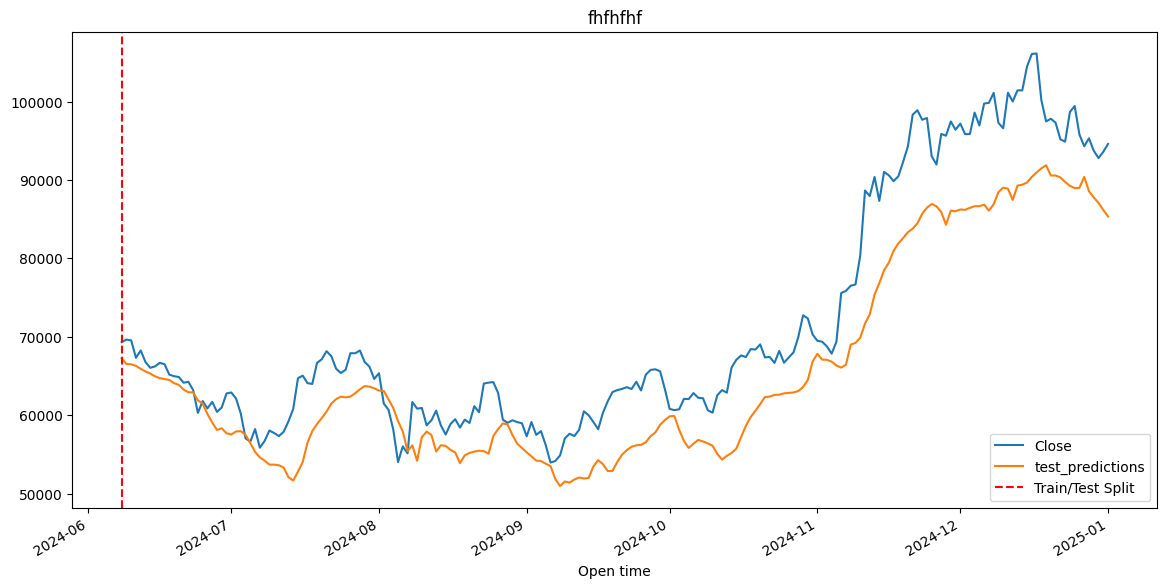

In [14]:
df["test_predictions"] = np.nan
df.loc[df.index[-len(y_pred_inv):], "test_predictions"] = y_pred_inv
df[["Close", "test_predictions"]].iloc[-len(y_pred_inv):].plot(figsize=(14, 7), title="fhfhfhf")

plt.axvline(x=df.index[-len(y_pred_inv)], color='red', linestyle='--', label='Train/Test Split')
plt.legend()

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


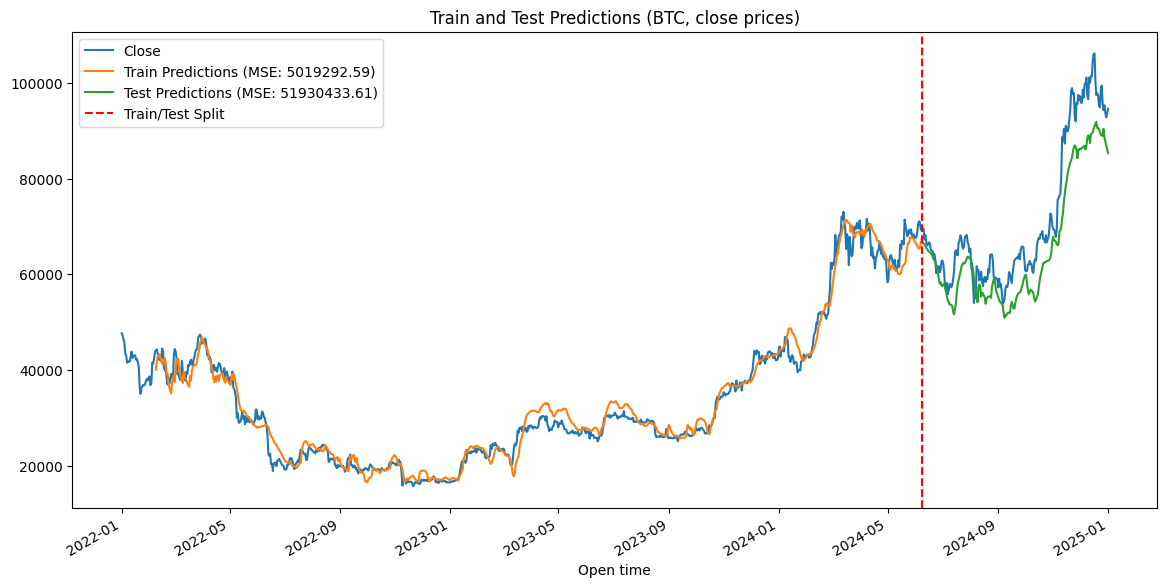

In [ ]:
# Generate predictions for the training set
train_X = best_data_scaled[:-len(best_y_val)]
train_y = best_df_all[TARGET].iloc[:-len(best_y_val)].values

# Build sequences for training predictions
train_sequences = [
    train_X[i-sequence_length:i]
    for i in range(sequence_length, len(train_X))
]
train_sequences = np.array(train_sequences)

# Predict on the training set
train_y_pred = best_model.predict(train_sequences).flatten()

# Create a placeholder array with zeros, except for the last column (target)
dummy_train = np.zeros((len(train_y_pred), train_sequences.shape[2]))
dummy_train[:, -1] = train_y_pred

# Inverse transform using the entire dummy array
train_y_pred_inv = best_scaler.inverse_transform(dummy_train)[:, -1]

# Add train predictions to the dataframe
df["train_predictions"] = np.nan
df.loc[df.index[sequence_length:len(train_y_pred) + sequence_length], "train_predictions"] = train_y_pred_inv

# Plot the entire timeframe with train and test predictions
df[["Close", "train_predictions", "test_predictions"]].plot(figsize=(14, 7), title="Train and Test Predictions (BTC, close prices)")

plt.axvline(x=df.index[-len(y_pred_inv)], color='red', linestyle='--', label='Train/Test Split')
plt.legend()
# Calculate MSE for train and test predictions
mse_train = mean_squared_error(df.loc[df.index[sequence_length:len(train_y_pred) + sequence_length], "Close"], train_y_pred_inv)
mse_test = mean_squared_error(val_predictions["Actual"], val_predictions["Predicted"])

# Update legend with MSE values
plt.legend([
    f"Close",
    f"Train Predictions (MSE: {mse_train:.2f})",
    f"Test Predictions (MSE: {mse_test:.2f})",
    f"Train/Test Split"
])

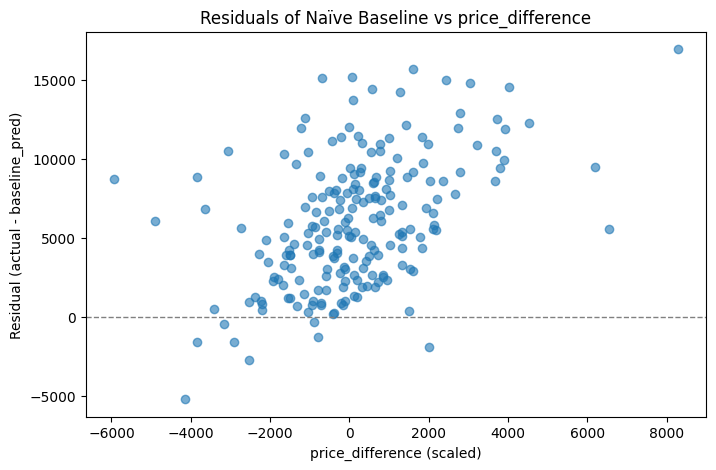

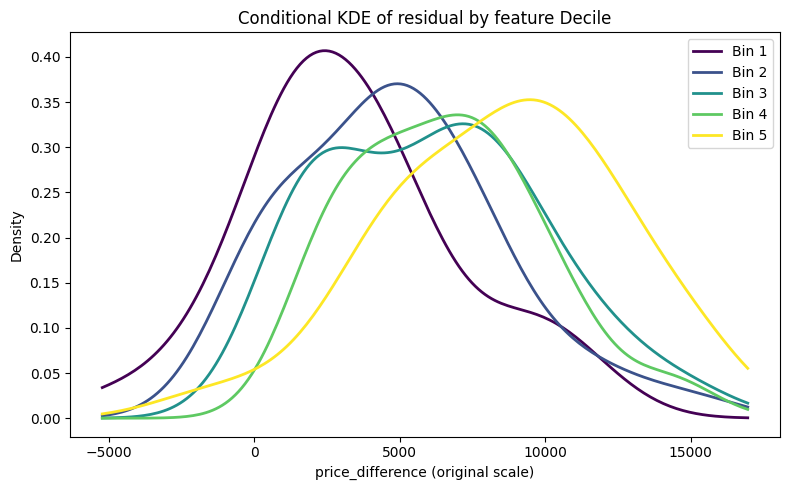

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats



# 3) Compute residuals relative to baseline
# residuals_baseline = preds - baseline_preds
residuals_baseline = y_val_inv - y_pred_inv

# 4) Extract the same feature (e.g. 'RSI') for X-axis
feature_to_plot = 'price_difference'  # or 'RSI', etc.

X_feat = y_val_inv - pd.Series(y_val_inv).shift(1)


# 5) Plot residuals of the benchmark vs. feature
plt.figure(figsize=(8,5))
plt.scatter(X_feat, residuals_baseline, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f'{feature_to_plot} (scaled)')
plt.ylabel('Residual (actual - baseline_pred)')
plt.title(f'Residuals of Naïve Baseline vs {feature_to_plot}')
plt.show()


# fig, (ax_scatter, ax_hist) = plt.subplots(2, 1, figsize=(8, 10))

# # Scatter: baseline residuals vs feature
# ax_scatter.scatter(X_feat, residuals_baseline, alpha=0.6)
# ax_scatter.axhline(0, color='gray', linestyle='--', linewidth=1)
# ax_scatter.set_xlabel(f'{feature_to_plot} (scaled)')
# ax_scatter.set_ylabel('Residual (actual - baseline_pred)')
# ax_scatter.set_title(f'Residuals of Naïve Baseline vs {feature_to_plot}')

data = pd.DataFrame({'X': residuals_baseline, 'Y': X_feat})
data.dropna(inplace=True)


# bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
# cond_vals = []
# for i in range(len(bins)-1):
#     mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
#     x_bin = data.loc[mask, 'X']
#     if len(x_bin) > 1:
#         x_std = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
#         cond_vals.append(x_std)
# cond_X = pd.concat(cond_vals, ignore_index=True)

# ax_hist.hist(cond_X, bins=30, density=True, alpha=0.7)
# ax_hist.set_xlabel(f'{feature_to_plot} (standardized within Y-bins)')
# ax_hist.set_ylabel('Density')
# ax_hist.set_title('Distribution of Detrended Conditional Feature')

# plt.tight_layout()
# plt.show()

bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
bins = np.quantile(data['Y'], np.linspace(0, 1, 6))

# Prepare a grid for plotting
x_min, x_max = data['X'].min(), data['X'].max()
x_grid = np.linspace(x_min, x_max, 200)

# Choose a colormap and number of bins
cmap = plt.get_cmap("viridis")
n_bins = len(bins) - 1
z_grid = np.linspace(-3, 3, 200)   # covers ±3σ

plt.figure(figsize=(8,5))
for i in range(n_bins):
    mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
    x_bin = data.loc[mask, 'X']
    if len(x_bin) > 1:
        # Standardize within bin
        mean_i = x_bin.mean()
        std_i  = x_bin.std(ddof=0)
        x_std = (x_bin - mean_i) / std_i
        
        # Fit KDE on standardized data
        kde = stats.gaussian_kde(x_std)
        
        # Evaluate KDE on grid (standardize grid same as x_bin)
        x_std_grid = (x_grid - mean_i) / std_i
        y_kde = kde(x_std_grid)

        
        z = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
        # fit KDE
        kde = stats.gaussian_kde(z)
        # evaluate on the z-grid
        y_kde = kde(z_grid)
        
        # Compute color and line width as gradient
        frac = i / (n_bins - 1)
        color = cmap(frac)
        # linewidth = 0.5 + 2.5 * frac
        linewidth = 2

        if len(x_bin) < 30:
            alpha = 0.5
            linewidth = 0.5
        else:
            alpha = 1
        
        plt.plot(
            x_grid, kde(x_std_grid),
            color=color,
            linewidth=linewidth,
            label=f'Bin {i+1}',
            alpha=alpha
        )
        plt.xlabel(f'{feature_to_plot} (original scale)')
        plt.ylabel('Density')

        # plt.plot(
        #     z_grid, kde(z_grid),
        #     color=cmap(frac),
        #     linewidth=0.5 + 2.5*frac,
        #     label=f'Bin {i+1}'
        # )
        # plt.xlabel(f'z-score of {feature_to_plot}')
        # plt.ylabel('Density')

plt.title('Conditional KDE of residual by feature Decile')
plt.legend()
# Optional: only show legend if desired
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
# Save the trained model
best_model.save(SAVE_MODEL)

# Save the scaler
joblib.dump(best_scaler, SAVE_SCALER)

# Save the dataframe
best_df_all.to_csv(SAVE_DF)

# Save validation predictions with date index
val_predictions = pd.DataFrame({
    "Date": df.index[-len(best_y_val):],
    "Actual": y_val_inv,
    "Predicted": y_pred_inv
})
val_predictions.set_index("Date", inplace=True)
val_predictions.to_csv(SAVE_PREDICTIONS)